In [26]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Activation
from tensorflow.keras import Model
import numpy as np
from utils.data_manager import ClutteredMNIST
from utils.visualizer import plot_mnist_sample
from utils.visualizer import print_evaluation
from utils.visualizer import plot_mnist_grid
from components.STN import BilinearInterpolation

## Dataset creation

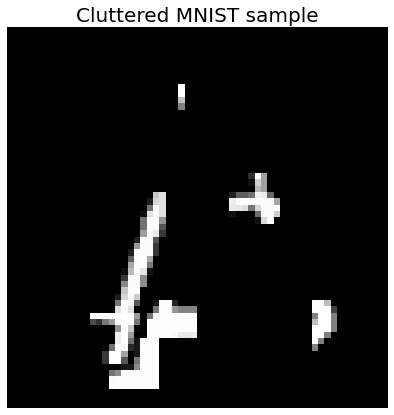

In [27]:
dataset_path = "./datasets/mnist_cluttered_60x60_6distortions.npz"
batch_size = 256
num_epochs = 30

data_manager = ClutteredMNIST(dataset_path)
train_data, val_data, test_data = data_manager.load()
x_train, y_train = train_data
plot_mnist_sample(x_train[7])

## Sampling layer

In [28]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [29]:
intermediate_dim = 64
latent_dim = 6
num_classes = 10

In [30]:
image = Input(shape=(60, 60, 1))
locnet = Flatten()(image)
locnet = Dense(intermediate_dim, activation='relu')(locnet)

locnet_mean = Dense(latent_dim)(locnet)
locnet_var = Dense(latent_dim)(locnet)

z_where = Sampling()((locnet_mean, locnet_var))

x = BilinearInterpolation((30, 30))([image, z_where])

x = Conv2D(32, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(32, (3, 3))(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = Dense(num_classes)(x)
x = Activation('softmax')(x)

model = Model(inputs=image, outputs=x)


In [32]:
kl_loss = - 0.5 * tf.reduce_mean(
        locnet_var - tf.square(locnet_mean) - tf.exp(locnet_var) + 1)
model.add_loss(kl_loss)

In [36]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [37]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60, 60, 1)]  0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 3600)         0           input_3[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 64)           230464      flatten_4[0][0]                  
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 6)            390         dense_10[0][0]                   
____________________________________________________________________________________________

## Training

In [38]:
model.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.1)

Epoch 1/100
1407/1407 [==============================] - 30s 21ms/step - loss: 2.3140 - val_loss: 2.3143
Epoch 2/100
1407/1407 [==============================] - 29s 20ms/step - loss: 2.3127 - val_loss: 2.3159
Epoch 3/100
1407/1407 [==============================] - 29s 21ms/step - loss: 2.3142 - val_loss: 2.3192
Epoch 4/100
1407/1407 [==============================] - 29s 20ms/step - loss: 2.3132 - val_loss: 2.3122
Epoch 5/100
1407/1407 [==============================] - 28s 20ms/step - loss: 2.3142 - val_loss: 2.3118
Epoch 6/100
1407/1407 [==============================] - 29s 21ms/step - loss: 2.3141 - val_loss: 2.3269
Epoch 7/100
1407/1407 [==============================] - 28s 20ms/step - loss: 2.3129 - val_loss: 2.3084
Epoch 8/100
1407/1407 [==============================] - 29s 20ms/step - loss: 2.3136 - val_loss: 2.3176
Epoch 9/100
1407/1407 [==============================] - 28s 20ms/step - loss: 2.3140 - val_loss: 2.3096
Epoch 10/100
1407/1407 [==============================]

KeyboardInterrupt: 

In [ ]:
input_image = model.input
output_STN = model.get_layer('bilinear_interpolation_1').output

STN_function = tf.keras.backend.function([input_image], [output_STN])

In [ ]:
plot_mnist_grid(x_train[20:30])
plot_mnist_grid(x_train[20:30], STN_function)